<a href="https://colab.research.google.com/github/pacnpacn/BUGAN/blob/master/script_GANvoxel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#right click shared folder IRCMS_GAN_collaborative_database and "Add shortcut to Drive" to My drive
%cd drive/My Drive/IRCMS_GAN_collaborative_database/Research/Peter/Tree_3D_models_obj/generated_files/
!ls

/content/drive/.shortcut-targets-by-id/1ylB2p6N0qQ-G4OsBuwcZ9C0tsqVu9ww4/IRCMS_GAN_collaborative_database/Research/Peter/Tree_3D_models_obj/generated_files
discriminator.pth	  maple_3_voxel_size03.ply
generator.pth		  old_1_voxel_size03.ply
maple_1_voxel_size03.ply  old_2_voxel_size03.ply
maple_1_voxel_size05.ply  old_3_voxel_size03.ply
maple_1_voxel_size1.ply   script_load3Dobj.i_voxel_size03.ply
maple_2_voxel_size03.ply  wandb


In [3]:
!pip install open3d
!pip install wandb -q

#add libraries, and login to wandb

In [4]:
import open3d as o3d
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

# WandB – Import the wandb library
import wandb

In [5]:
!wandb login

wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 3ee9555f5fe9ec64586fefd263b8453dd4b4ea3b
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [6]:

wandb.init(project="bugan-basicgan")
wandb.watch_called = False

In [7]:
#keep track of hyperparams
config = wandb.config
config.batch_size = 1
config.test_batch_size = 1
config.epochs = 50
config.g_lr = 0.0003
config.d_lr = 0.0003               
config.seed = 1234
config.log_interval = 10

#dataset

In [8]:
def voxel2arrayCentered(voxel, tree_size_scale = 1):
    array_size = np.array([250, 250, 250])
    vox_array = np.zeros(array_size, dtype=int)  
    tree_size = np.array(voxel.get_axis_aligned_bounding_box().get_extent())
    tree_size = np.ceil(tree_size / tree_size_scale)    #voxel_size = tree_size_scale
    tree_center = (np.ceil(tree_size / 2)).astype(int)

    vox_list = voxel.get_voxels()
    for vox in vox_list:
        coord = vox.grid_index
        #center the tree
        coord = coord - tree_center + (array_size/2)
        coord = tuple(coord.astype(int))

        vox_array[coord] = 1.

    return vox_array.astype(bool)

In [9]:
#process all files in the generated file folder to generate dataset 
import os

dataset = []
for file_name in os.listdir():
    if file_name.endswith("voxel_size03.ply"):
        #note that the voxel_size of vox is 0.3, so we scale it back to one for indexing
        print(file_name)
        dataset.append(voxel2arrayCentered(o3d.io.read_voxel_grid(file_name), 0.3))


maple_2_voxel_size03.ply
maple_3_voxel_size03.ply
maple_1_voxel_size03.ply
script_load3Dobj.i_voxel_size03.ply
old_1_voxel_size03.ply
old_2_voxel_size03.ply
old_3_voxel_size03.ply


In [10]:
dataset = torch.tensor(dataset)
print(torch.unsqueeze(dataset, -1).shape)
tensor_dataset = TensorDataset(torch.unsqueeze(dataset, 1))
dataloader = DataLoader(tensor_dataset, batch_size=config.batch_size)

torch.Size([7, 250, 250, 250, 1])


#model description

In [11]:
#input: 128-d noise vector
#output: (250,250,250) array with values in [0,1]

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.gen_fc = nn.Linear(128, 16 * 5 * 5 * 5)
        self.gen = nn.Sequential(
            nn.ConvTranspose3d(16, 32, 5, 2),
            nn.BatchNorm3d(32),
            nn.ReLU(True),
            nn.ConvTranspose3d(32, 32, 5, 2),
            nn.BatchNorm3d(32),
            nn.ReLU(True),
            nn.ConvTranspose3d(32, 32, 5, 2),
            nn.BatchNorm3d(32),
            nn.ReLU(True),
            nn.ConvTranspose3d(32, 32, 3, 2),
            nn.BatchNorm3d(32),
            nn.ReLU(True),
            nn.ConvTranspose3d(32, 16, 3, 2),
            nn.BatchNorm3d(16),
            nn.ReLU(True),
            nn.ConvTranspose3d(16, 1, 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):

        x = self.gen_fc(x)
        x = x.view(x.shape[0], 16, 5, 5, 5)
        x = self.gen(x)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.dis = nn.Sequential(
            nn.Conv3d(1, 16, 5, 1),
            nn.LeakyReLU(0.1, True),
            nn.MaxPool3d((2, 2, 2)),
            nn.Conv3d(16, 32, 5, 1),
            nn.LeakyReLU(0.1, True),
            nn.MaxPool3d((2, 2, 2)),
            nn.Conv3d(32, 32, 5, 1),
            nn.LeakyReLU(0.1, True),
            nn.MaxPool3d((2, 2, 2)),
            nn.Conv3d(32, 16, 5, 1),
            nn.LeakyReLU(0.1, True),
            nn.MaxPool3d((2, 2, 2)),
            nn.Conv3d(16, 16, 5, 1),
            nn.LeakyReLU(0.1, True),
            nn.Conv3d(16, 8, 5, 1),
            nn.LeakyReLU(0.1, True),
        )

        self.dis_fc = nn.Sequential(
            nn.Linear(8 * 3 * 3 * 3, 128),
            nn.LeakyReLU(0.1, True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):

        x = self.dis(x)
        x = x.view(x.shape[0], -1)
        x = self.dis_fc(x)
        return x

In [12]:
G = Generator().to(device)
summary(G, (128,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2000]         258,000
   ConvTranspose3d-2       [-1, 32, 13, 13, 13]          64,032
       BatchNorm3d-3       [-1, 32, 13, 13, 13]              64
              ReLU-4       [-1, 32, 13, 13, 13]               0
   ConvTranspose3d-5       [-1, 32, 29, 29, 29]         128,032
       BatchNorm3d-6       [-1, 32, 29, 29, 29]              64
              ReLU-7       [-1, 32, 29, 29, 29]               0
   ConvTranspose3d-8       [-1, 32, 61, 61, 61]         128,032
       BatchNorm3d-9       [-1, 32, 61, 61, 61]              64
             ReLU-10       [-1, 32, 61, 61, 61]               0
  ConvTranspose3d-11    [-1, 32, 123, 123, 123]          27,680
      BatchNorm3d-12    [-1, 32, 123, 123, 123]              64
             ReLU-13    [-1, 32, 123, 123, 123]               0
  ConvTranspose3d-14    [-1, 16, 247, 2

In [13]:
D = Discriminator().to(device)
summary(D, (1, 250, 250, 250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 16, 246, 246, 246]           2,016
         LeakyReLU-2    [-1, 16, 246, 246, 246]               0
         MaxPool3d-3    [-1, 16, 123, 123, 123]               0
            Conv3d-4    [-1, 32, 119, 119, 119]          64,032
         LeakyReLU-5    [-1, 32, 119, 119, 119]               0
         MaxPool3d-6       [-1, 32, 59, 59, 59]               0
            Conv3d-7       [-1, 32, 55, 55, 55]         128,032
         LeakyReLU-8       [-1, 32, 55, 55, 55]               0
         MaxPool3d-9       [-1, 32, 27, 27, 27]               0
           Conv3d-10       [-1, 16, 23, 23, 23]          64,016
        LeakyReLU-11       [-1, 16, 23, 23, 23]               0
        MaxPool3d-12       [-1, 16, 11, 11, 11]               0
           Conv3d-13          [-1, 16, 7, 7, 7]          32,016
        LeakyReLU-14          [-1, 16, 

#functions for pytorch network

In [18]:
#TODO: add train and test log
def train_model(generator, discriminator, dataloader):   
    #set seed
    torch.manual_seed(config.seed)
    # torch.backends.cudnn.deterministic = True

    generator.to(device)
    discriminator.to(device)
    
    #loss function
    criterion = nn.BCELoss(reduction='sum')
    #optimizer
    dis_optimizer = optim.Adam(discriminator.parameters(), lr=config.d_lr)
    gen_optimizer = optim.Adam(generator.parameters(), lr=config.g_lr)   

    generator.train()
    discriminator.train()

    #log models
    wandb.watch(generator, log="all")
    wandb.watch(discriminator, log="all")

    d_losses = []
    g_losses = []
    for epoch in range(config.epochs):
        d_ep_loss = 0.
        g_ep_loss = 0.
        for dataset_batch in dataloader:
            dataset_batch = dataset_batch[0]
            dataset_batch = dataset_batch.float().to(device)
            batch_size = dataset_batch.shape[0]
            
            #labels
            real_label = torch.unsqueeze(torch.ones(batch_size),1).to(device)
            fake_label = torch.unsqueeze(torch.zeros(batch_size),1).to(device)

            
            ############
            #train discriminator
            ############
            #generate fake trees
            z = torch.randn(batch_size, 128).to(device) #128-d noise vector
            tree_fake = generator(z)

            #real data (data from dataloader)
            dout_real = discriminator(dataset_batch)
            dloss_real = criterion(dout_real, real_label)
            score_real = dout_real
            #fake data (data from generator)            
            dout_fake = discriminator(tree_fake.detach())   #detach so no double update on the same batch of tree_fake
            dloss_fake = criterion(dout_fake, fake_label)
            score_fake = dout_fake

            #loss function (discriminator classify real data vs generated data)
            dloss = dloss_real + dloss_fake

            #optimize discriminator
            dis_optimizer.zero_grad()
            dloss.backward()
            dis_optimizer.step()

            #record loss
            d_ep_loss += dloss.detach()

            ############
            #train generator
            ############

            #tree_fake is already computed above
            dout_fake = discriminator(tree_fake)
            #generator should generate trees that discriminator think they are real
            gloss = criterion(dout_fake, real_label)    

            #optimize generator
            gen_optimizer.zero_grad() 
            gloss.backward()
            gen_optimizer.step()

            #record loss
            g_ep_loss += gloss.detach()

        #after each epoch, record total loss
        d_losses.append(d_ep_loss)
        g_losses.append(g_ep_loss)
        print("discriminator, epoch"+str(epoch)+" : "+str(d_ep_loss))
        print("generator, epoch"+str(epoch)+" : "+str(g_ep_loss))

        #save model if necessary
        if epoch % 10 == 0:
            torch.save(generator.state_dict(), os.path.join(wandb.run.dir, 'generator.pth'))
            torch.save(discriminator.state_dict(), os.path.join(wandb.run.dir, 'discriminator.pth'))
    
    #training end, save model again
    torch.save(generator.state_dict(), os.path.join(wandb.run.dir, 'generator.pth'))
    torch.save(discriminator.state_dict(), os.path.join(wandb.run.dir, 'discriminator.pth'))
    print(d_losses)
    print(g_losses)

#this is the same as train_model, except it will only evaluate loss but not update model 
def loss_eval(generator, discriminator, dataloader):
    torch.manual_seed(config.seed)
    # torch.backends.cudnn.deterministic = True

    generator.to(device)
    discriminator.to(device)
    
    #loss function
    criterion = nn.BCELoss(reduction='sum')   

    generator.eval()
    discriminator.eval()

    d_ep_loss = 0.
    g_ep_loss = 0.
    for dataset_batch in dataloader:
        dataset_batch = dataset_batch[0]
        dataset_batch = dataset_batch.float().to(device)
        batch_size = dataset_batch.shape[0]
        
        #labels
        real_label = torch.unsqueeze(torch.ones(batch_size),1).to(device)
        fake_label = torch.unsqueeze(torch.zeros(batch_size),1).to(device)

        ############
        #discriminator
        ############
        #generate fake trees
        z = torch.randn(batch_size, 128).to(device) #128-d noise vector
        tree_fake = generator(z)

        #real data (data from dataloader)
        dout_real = discriminator(dataset_batch)
        dloss_real = criterion(dout_real, real_label)
        score_real = dout_real
        #fake data (data from generator)            
        dout_fake = discriminator(tree_fake.detach())   #detach so no double update on the same batch of tree_fake
        dloss_fake = criterion(dout_fake, fake_label)
        score_fake = dout_fake

        #loss function (discriminator classify real data vs generated data)
        dloss = dloss_real + dloss_fake

        #record loss
        d_ep_loss += dloss.detach()

        ############
        #train generator
        ############

        #tree_fake is already computed above
        dout_fake = discriminator(tree_fake)
        #generator should generate trees that discriminator think they are real
        gloss = criterion(dout_fake, real_label)    

        #record loss
        g_ep_loss += gloss.detach()

    print("discriminator loss: "+str(d_ep_loss))
    print("generator loss: "+str(g_ep_loss))


def save_model(generator, discriminator, g_path = os.path.join(wandb.run.dir, 'generator.pth') , d_path = os.path.join(wandb.run.dir, 'discriminator.pth')):
    torch.save(generator.state_dict(), g_path)
    torch.save(discriminator.state_dict(), d_path)

def load_model(g_path = os.path.join(wandb.run.dir, 'generator.pth'), d_path = os.path.join(wandb.run.dir, 'discriminator.pth')):
    generator = Generator()
    generator.load_state_dict(torch.load(g_path))
    generator.eval()

    discriminator = Discriminator()
    discriminator.load_state_dict(torch.load(d_path))
    discriminator.eval()
    return generator, discriminator

def generate_tree(generator, num_trees = 1):
    torch.manual_seed(config.seed)
    torch.backends.cudnn.deterministic = True
    
    #generate noise vector
    z = torch.randn(num_trees, 128).to(device)
    generator.to(device).eval()
    tree_fake = generator(z)
    return tree_fake.detach().cpu().numpy()

#train

In [19]:
G = Generator()
D = Discriminator()
# loss_eval(G, D, dataloader)
train_model(G, D, dataloader)        #given dataloader has only 1 model, the training time is 72s per epoch.
# loss_eval(G, D, dataloader)

discriminator, epoch0 : tensor(9.1325, device='cuda:0')
generator, epoch0 : tensor(8.1705, device='cuda:0')
discriminator, epoch1 : tensor(6.5544, device='cuda:0')
generator, epoch1 : tensor(20.3887, device='cuda:0')
discriminator, epoch2 : tensor(1.7195, device='cuda:0')
generator, epoch2 : tensor(47.6681, device='cuda:0')
discriminator, epoch3 : tensor(0.0326, device='cuda:0')
generator, epoch3 : tensor(84.7063, device='cuda:0')
discriminator, epoch4 : tensor(3.3171, device='cuda:0')
generator, epoch4 : tensor(28.2940, device='cuda:0')
discriminator, epoch5 : tensor(14.8030, device='cuda:0')
generator, epoch5 : tensor(6.3672, device='cuda:0')
discriminator, epoch6 : tensor(1.1111, device='cuda:0')
generator, epoch6 : tensor(38.3148, device='cuda:0')
discriminator, epoch7 : tensor(0.2915, device='cuda:0')
generator, epoch7 : tensor(23.6775, device='cuda:0')
discriminator, epoch8 : tensor(0.3302, device='cuda:0')
generator, epoch8 : tensor(21.9518, device='cuda:0')
discriminator, epoch

In [20]:
vox_array = generate_tree(G)
vox_array = vox_array > 0.5
print(vox_array.shape)

(1, 1, 250, 250, 250)


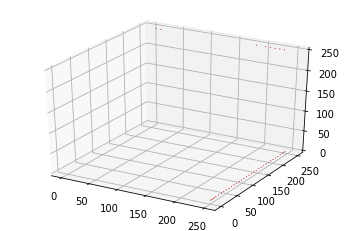

In [21]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.gca(projection='3d')

ax.voxels(vox_array[0,0], facecolors='red')

plt.show()